# Procesamiento de Lenguaje Natural

**Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Latent Dirichlet Allocation (LDA) para modelado de tópicos

En este notebook vamos implementar LDA sobre el dataset [NeurIPS papers](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv). Este dataset contiene los títulos, abstract y texto de los artículos publicados en la conferencia [NeurIPS (antes NIPS)](https://nips.cc/), la internacional conferencia más importante en aspecto relacionados con aprendizaje automático.

In [1]:
%matplotlib inline  
# Figures plotted inside the notebook
%config InlineBackend.figure_format = 'retina'
# High quality figures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
#!pip install pyldavis

In [3]:
papers =  pd.read_csv("http://www.tsc.uc3m.es/~olmos/BBVA/papers.csv")

#papers =  pd.read_csv("papers.csv")

Nos vamos a quedar con los artículos más recientes, a partir de 2010 ...

In [4]:
recent_nips = papers.loc[papers['year']>=2010].copy()

In [5]:
recent_nips

,source_id,year,title,abstract,full_text
3853,363,2010,Agnostic Active Learning Without Constraints,We present and analyze an agnostic active lear...,Agnostic Active Learning Without Constraints\n...
3854,1164,2010,A Dirty Model for Multi-task Learning,We consider the multiple linear regression pro...,A Dirty Model for Multi-task Learning\n\nAli J...
3855,348,2010,Generative Local Metric Learning for Nearest N...,We consider the problem of learning a local me...,Generative Local Metric Learning for\n\nNeares...
3856,899,2010,Relaxed Clipping: A Global Training Method for...,Robust regression and classification are often...,Relaxed Clipping: A Global Training Method\n\n...
3857,1195,2010,Linear readout from a neural population with p...,How much information does a neural population ...,Linear readout from a neural population\n\nwit...
...,...,...,...,...,...
9675,5452,2019,Discrete Object Generation with Reversible Ind...,The success of generative modeling in continuo...,Discrete Object Generation\n\nwith Reversible ...
9676,4799,2019,Adaptively Aligned Image Captioning via Adapti...,Recent neural models for image captioning usua...,Adaptively Aligned Image Captioning via\n\nAda...
9677,1827,2019,Fully Dynamic Consistent Facility Location,We consider classic clustering problems in ful...,Fully Dynamic Consistent Facility Location\n\n...
9678,8693,2019,Efficient Rematerialization for Deep Networks,"When training complex neural networks, memory ...",Efﬁcient Rematerialization for Deep Networks\n...


Además, vamos a concatenar título y abstract para hacer LDA con el campo resultante:

In [6]:
recent_nips['Title_abstract'] = recent_nips['title'].map(str) + ' ' + recent_nips['abstract'].astype(str)

Vamos a normalizar el dataset, elimnando stopping words y signos de puntuación ...

In [7]:
import spacy

nlp = spacy.load("en_core_web_md")

def normalize(doc):
    
    return [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct and w.is_alpha] # Solo tokens alfabéticos




In [8]:
papers_norm = [normalize(nlp(s)) for s in recent_nips['Title_abstract']]

Para validar el número de tópicos, vamos a dividir en entrenamiento y validación. Para ello, hacemos un random  shuffle (originalmente los artículos están ordenados por fecha) y partimos:

In [9]:
import random

random.shuffle(papers_norm )
               
papers_norm_train = papers_norm[:5000]

papers_norm_val = papers_norm[5000:]

Creamos el diccionario y lo filtramos, importante para obtener topicos interpretables

In [10]:
import gensim

D = gensim.corpora.Dictionary(papers_norm_train)

n_tokens = len(D)

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .30 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 2928 terms
First terms in the dictionary:
0 : architecture
1 : attention
2 : batch
3 : bias
4 : complete
5 : compose
6 : computation
7 : connect
8 : connection
9 : convolution


Obtenemos la matriz BOW ...

In [11]:
from gensim.models import TfidfModel

corpus_bow = [D.doc2bow(doc) for doc in papers_norm_train]

corpus_bow_val = [D.doc2bow(doc) for doc in papers_norm_val]

## Latent Dirichlet Allocation (LDA)

[**LDA es un modelo generativo probabilístico para textos**](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf). En particular, asumiendo un número $K$ de temas, LDA plantea el siguiente proceso generativo:

<kbd>
<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA_modelo.png' width=600 />
</kbd>

El proceso anterior, matemáticamente se define como un **modelo de mezcla de variables categóricas** (en lugar de Gaussianas como en un GMM). La siguiente figura ([Fuente](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)), resume el proceso anterior:

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA1.png' width=800 />

Es importante notar que $\theta_d$, la proporción de temas en cada documento es una **representación vectorial del mismo que resume su información**. Este vector puede ser utilizado como vector de características para realizar otros algoritmos de aprendizaje (búsqueda de vecinos más cercanos, clasificación de documentos, etc ...).

El objetivo en el entrenamiento LDA es, **dada una colección de documentos representados como un BoW** $\mathbf{X}= [\mathbf{x}_1,\ldots,\mathbf{x}_N]$, obtener la distribución  a posteriori de probabilidad $\beta_k$ de las palabras por cada tema, y la proporción de temas por documento $\theta_d$:

$$ p(\beta_k|\mathbf{X}), \qquad k=1, \ldots,K$$

$$ p(\theta_d|\mathbf{X}), \qquad d=1,\ldots N$$

Para obtener muestras de las distribuciones a posteriori anteriores se hace uso de técnicas de Monte Carlo  basadas en cadenas de Markov.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA2.png' width=1000 />

##  LDA con Gensim

Gensim proporciona una librería para entrenar un modelo [LDA](https://radimrehurek.com/gensim/models/ldamulticore.html) de forma online (podemos reentrenar a medida que incorporamos más documentos al dataset) y de forma distribuida, aprovechando todos los cores CPU para paralelizar y acelerar el entrenamiento del modelo.

In [12]:
lda_model = gensim.models.LdaMulticore(corpus_bow, num_topics=6, id2word = D, passes=5)

Vamos a imprimir las 10 palabras más probables en cada tópico:

In [13]:
for idx, topic in lda_model.print_topics():
    print("Topic: %d \nWords: %s" %(idx, topic))
    print("\n")

Topic: 0 
Words: 0.020*"network" + 0.014*"neural" + 0.011*"image" + 0.011*"task" + 0.010*"deep" + 0.009*"training" + 0.006*"train" + 0.006*"performance" + 0.006*"dataset" + 0.006*"layer"


Topic: 1 
Words: 0.020*"graph" + 0.019*"network" + 0.009*"neural" + 0.008*"structure" + 0.008*"inference" + 0.006*"large" + 0.006*"time" + 0.006*"function" + 0.005*"node" + 0.005*"sample"


Topic: 2 
Words: 0.010*"function" + 0.009*"gradient" + 0.009*"sample" + 0.008*"distribution" + 0.007*"optimization" + 0.007*"stochastic" + 0.006*"linear" + 0.006*"non" + 0.006*"provide" + 0.006*"convex"


Topic: 3 
Words: 0.008*"function" + 0.006*"time" + 0.006*"loss" + 0.006*"new" + 0.006*"bound" + 0.005*"state" + 0.005*"network" + 0.005*"optimal" + 0.005*"provide" + 0.005*"performance"


Topic: 4 
Words: 0.009*"latent" + 0.008*"inference" + 0.007*"state" + 0.006*"representation" + 0.006*"process" + 0.006*"prediction" + 0.006*"network" + 0.005*"task" + 0.005*"classification" + 0.005*"variational"


Topic: 5 
Word

In [14]:
#!pip install wordcloud

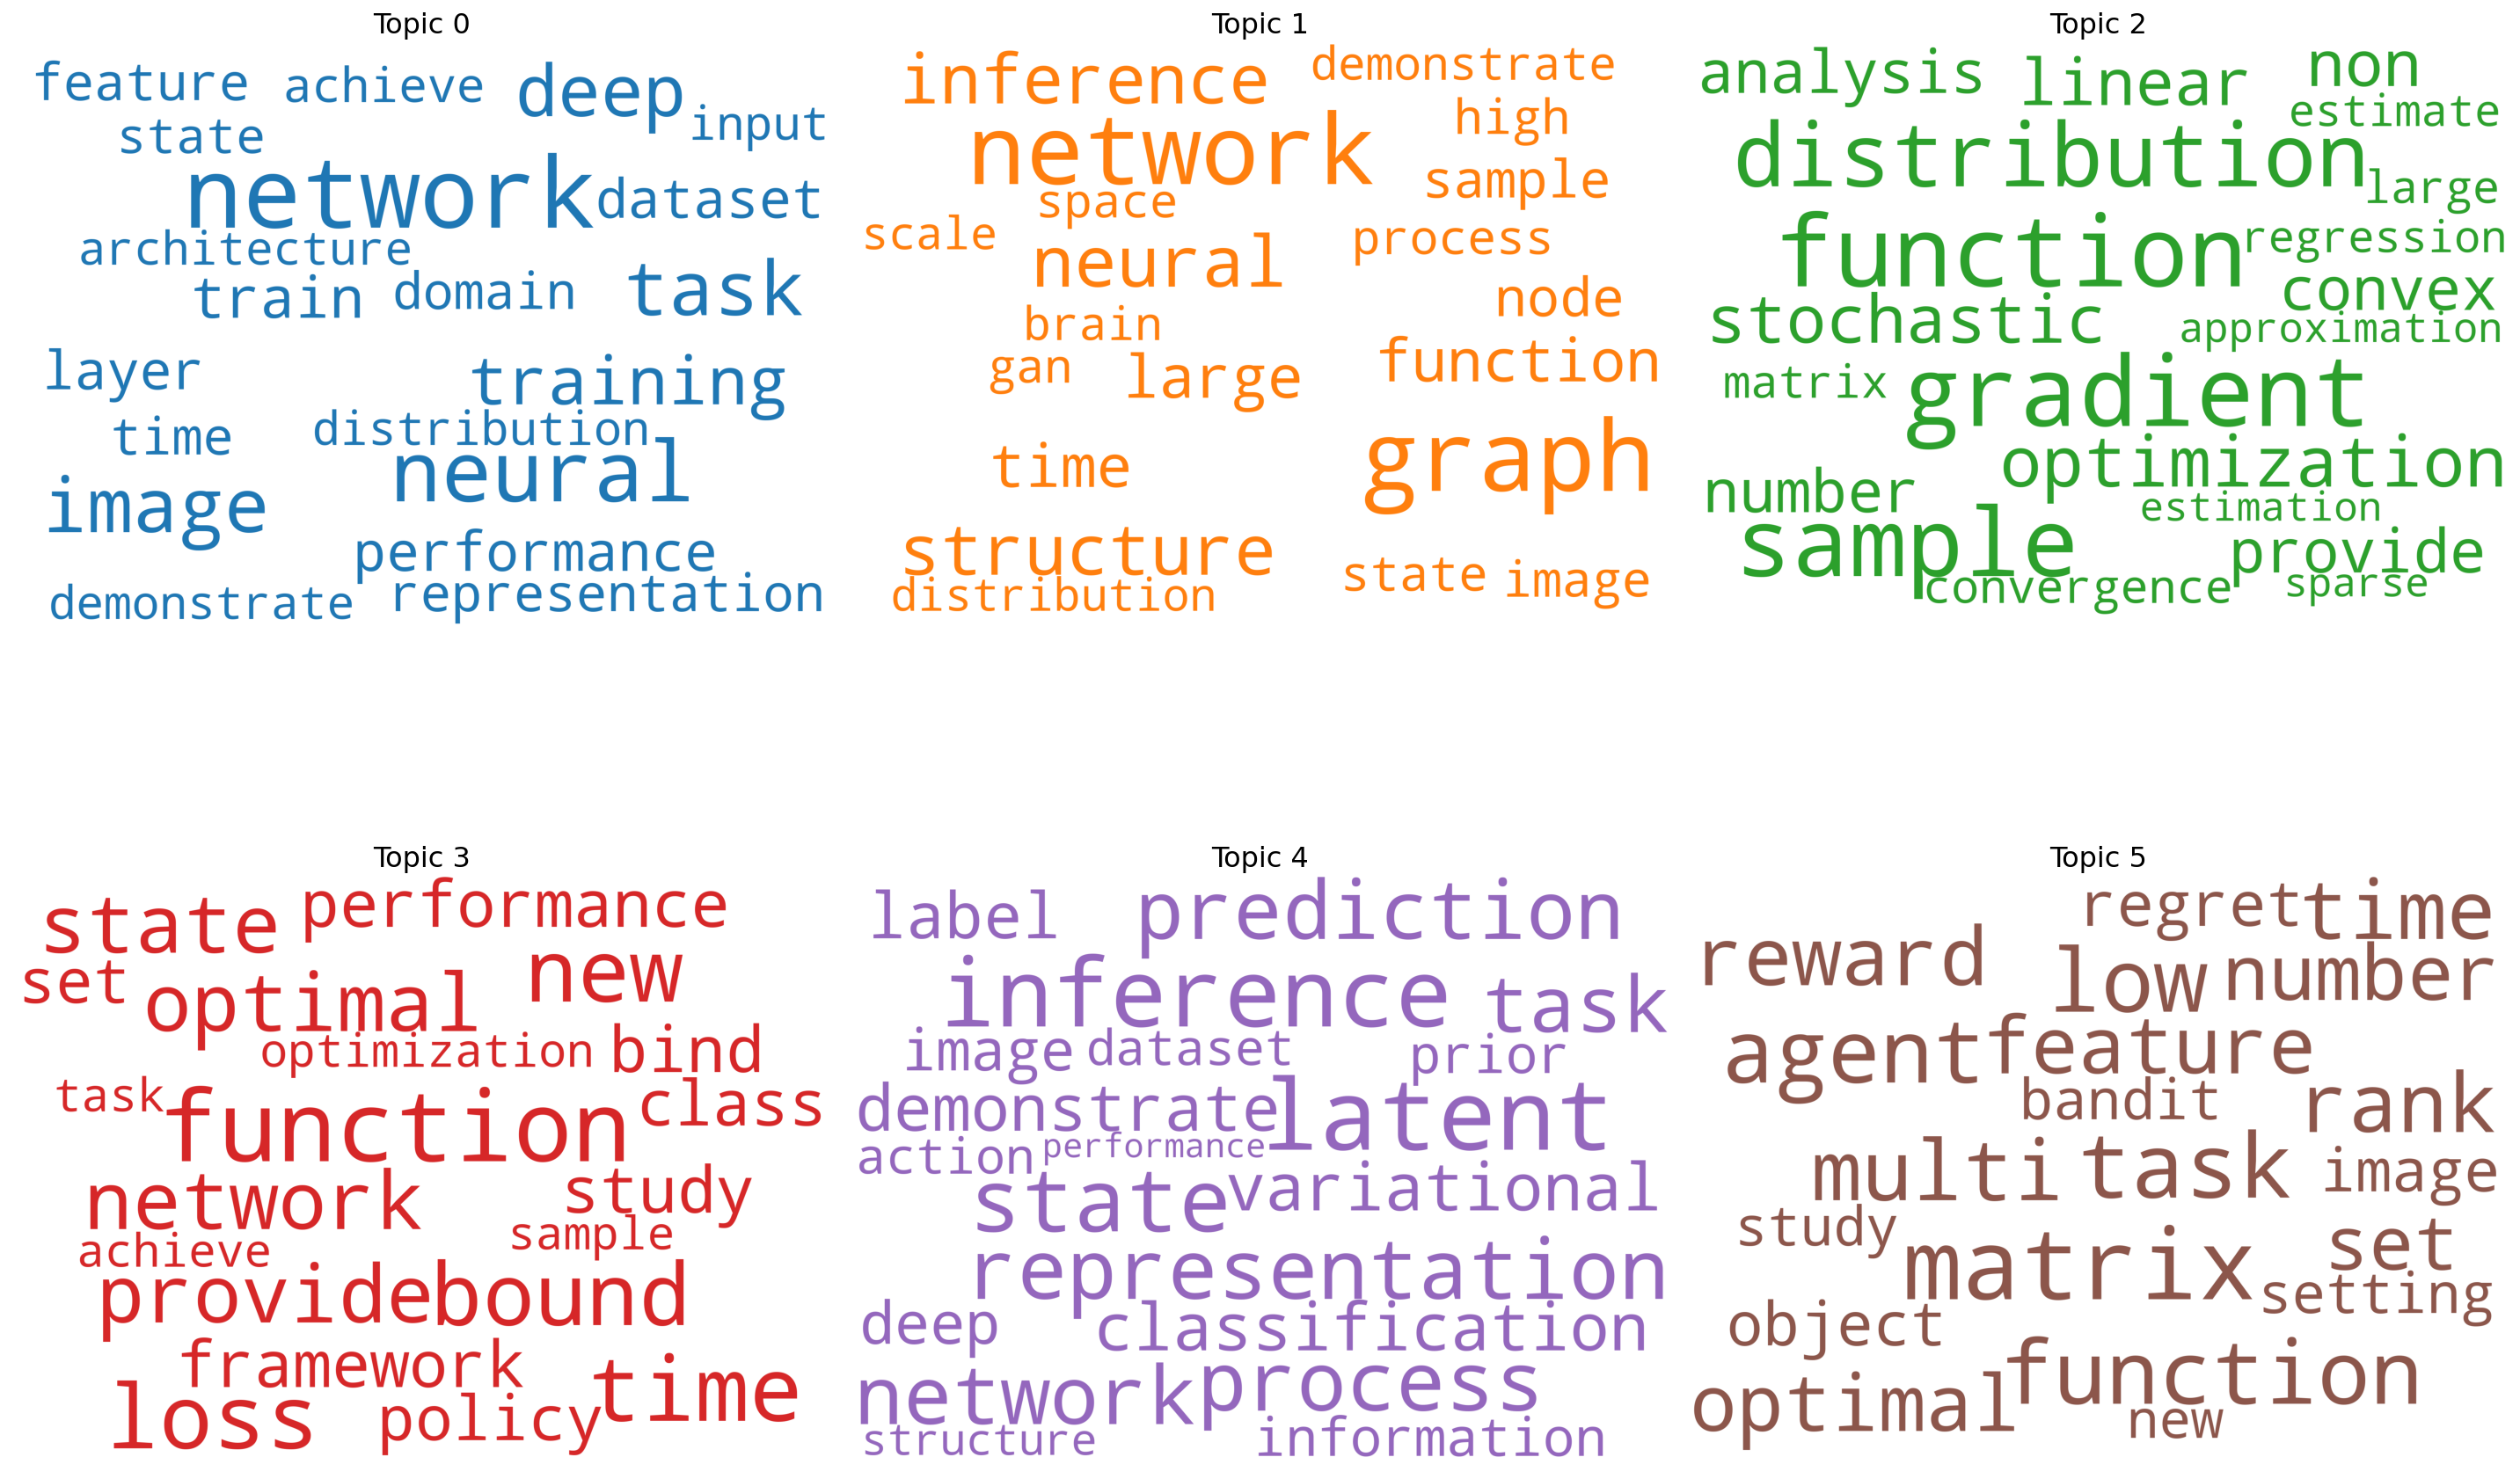

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(2, 3, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Y del siguiente modo calculamos la proporción de cada tópico por documento:

In [16]:
idx_document = 4000 #Índice del documento

print(recent_nips.iloc[idx_document]['Title_abstract'])

for index, score in lda_model[corpus_bow[idx_document]]:
    print("\nScore: %f\t \n Topic: %r" %(score, lda_model.print_topic(index, 20)))

Learning Optimal Reserve Price against Non-myopic Bidders We consider the problem of learning optimal reserve price in repeated auctions against non-myopic bidders, who may bid strategically in order to gain in future rounds even if the single-round auctions are truthful. Previous algorithms, e.g., empirical pricing, do not provide non-trivial regret rounds in this setting in general. We introduce algorithms that obtain small regret against non-myopic bidders either when the market is large, i.e., no bidder appears in a constant fraction of the rounds, or when the bidders are impatient, i.e., they discount future utility by some factor mildly bounded away from one. Our approach carefully controls what information is revealed to each bidder, and builds on techniques from differentially private online learning as well as the recent line of works on jointly differentially private algorithms.

Score: 0.724551	 
 Topic: '0.010*"function" + 0.009*"gradient" + 0.009*"sample" + 0.008*"distribu

Finalmente, con la siguiente función resumimos la proporción de temas para todos los artículos del dataset ...

In [17]:
# Vamos a pasar a una matriz las proporciones de temas por documento

topics_doc = lda_model[corpus_bow]

In [18]:
from gensim.matutils import corpus2dense

corpus_LDA_dense = corpus2dense(topics_doc, num_terms=6, num_docs=len(topics_doc)).T


In [19]:
corpus_LDA_dense.shape

(5000, 6)

### Selección del número de tópicos

Al tratarse de modelos no supervisados, no disponemos de una métrica unívoca para la validación de parámetros de un modelo de temas (típicamente el número de temas). En este [articulo](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) se hace un resumen muy completo de las distintas métricas en un modelo de temas que típicamente se utilizan de forma combinada. Por una parte, tenemos **métricas de ajuste** del modelo a datos de validación:

* **LL: log-likelihood**: dado un documento con palabras $\mathbf{w}_d$, log-probabilidad de ser una muestra del modelo LDA entrenado:

$$\log p(\mathbf{w}_d) = \log \int p(\theta_d)\prod_{k=1}^{K}p(\beta_k)\prod_{j=1}^{D_d} p(w_{jd}|\beta_{z_{jd}})p(z_{jd}|\theta_d)~d\beta_1\ldots d\beta_k d\theta_d d\mathbf{z}_d$$

* **LP: log_perplexity**: dado un conjunto de validación $\mathcal{D}_{\text {val}} =\left(\mathbf{w}_1,\ldots,\mathbf{w}_M\right)$, siendo $N_d$ el número de palabras del documento $d$, se define como

$$\text { perplexity }\left(\mathcal{D}_{\text {val}}\right)=\exp \left\{-\frac{\sum_{d=1}^{M} \log p\left(\mathbf{w}_{d}\right)}{\sum_{d=1}^{M} N_{d}}\right\}$$

$\quad$ A menor valor, mejor ajuste a los datos. **Nota:** `topic_model.log_perplexity` devuelve una cota inferior a $\sum_{d=1}^{M} \log p\left(\mathbf{w}_{d}\right)$, por tanto a mayor valor mejor ajuste.

Si bien estas métricas están relacionadas con el ajuste de los datos al modelo probabilístico de LDA, existen **métricas de coherencia** que se han demostrado más correladas con un criterio manual (una persona validando la interpretabilidad/coherencia de los temas encontrados). Estas métricas parten de tomar las $T$ palabras más relevantes por tema y promedia una medida de coherencia entre todos los posibles pares en este conjunto de $T$ palabras. A mayor valor, más coherencia interna en los temas:

* **UCI coherence score**: información mutua puntual (pointwise mutual information PMI) promedio entre los pares de palabras

$$C_{\mathrm{UCI}}=\frac{2}{T \cdot(T-1)} \sum_{i=1}^{T-1} \sum_{j=i+1}^{T} \operatorname{PMI}\left(w_{i}, w_{j}\right), \quad \operatorname{PMI}\left(w_{i}, w_{j}\right)=\log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{i}\right) \cdot P\left(w_{j}\right)}$$

* **UMass coherence**: probabilidad condicional promedio entre los pares de palabras

$$C_{\mathrm{UMass}}=\frac{2}{T \cdot(T-1)} \sum_{i=2}^{T} \sum_{j=1}^{i-1} \log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{j}\right)}$$

* Finalmente, existen varias métricas basadas en medir la distancia (e.g. distancia coseno) entre vectores de contexto asociados a cada una de las $T$ palabras. Una elección habitual del vector de contexto es utilizar PMI normalizada en palabras que aparecen en una ventana de $\pm5$ palabras. Para la palabra $w_i$ de las más relevantes del tema, construiremos el vector 
$\mathbf{v}_i$ de dimensión igual al diccionario, de forma que el elemento $j$ del vector $\mathbf{v}_i$ asociado a la palabra $w_i$ se calcula como
$$v_{i j}=\operatorname{NPMI}\left(w_{i}, w_{j}\right)^{\gamma}=\left(\frac{\log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{i}\right) \cdot P\left(w_{j}\right)}}{\log \left(P\left(w_{i}, w_{j}\right)+\epsilon\right)}\right)^{\gamma}, \qquad \gamma>0$$

Finalmente, dados los vectores contexto $\mathbf{v}_1,\ldots,\mathbf{v}_T$ calculamos la métrica de coherencia

$$C_{NPMI} = \frac{2}{T \cdot(T-1)} \sum_{i=1}^{T-1} \sum_{j=i+1}^{T} \text{dcos}(\mathbf{v}_i,\mathbf{v}_j)$$

Para el cálculo de las métricas anteriores, las probabilidades $P\left(w_{i}, w_{j}\right)$ y $P\left(w_{i}\right)$ se calculan a patir de una matriz de co-ocurrencias basada en una **ventana deslizante de tamaño $W$ sobre los textos del conjunto de validación**. 


Para el dataset anterior, vamos a generar un conjunto de entrenamiento/validación para ajustar el número $K$ de temas de LDA. A continuación usaremos la clase clase [`models.coherencemodel`](https://radimrehurek.com/gensim/models/coherencemodel.html) nos permite calcular las métricas anteriores de forma sencilla. A esta clase debemos pasarle los documentos de validación **sin vectorizar con BoW!!**, es necesario el texto natural para el cálculo de la matriz de co-ocurrencias en una ventana deslizante.

In [20]:
from gensim.models.coherencemodel import CoherenceModel

bow_train = corpus_bow

bow_val = corpus_bow_val

papers_train = papers_norm

papers_val = papers_norm_val

K_max = 10

L_UCI = []

L_mass = []

L_NPMI = []

L_perp = []

L_UCI_train = []

L_mass_train = []

L_NPMI_train = []

L_perp_train = []

topic_models = {}


for k in range(4,K_max,2):
    
    print(k)
    
    topic_models[k] = gensim.models.LdaMulticore(bow_train, num_topics=k, id2word = D, passes=30) # Utilizamos BOW en lugar de TF-IDF!
    
    #### Perplexity
    
    L_perp.append(topic_models[k].log_perplexity(bow_val))
    
    L_perp_train.append(topic_models[k].log_perplexity(bow_train))
    
    #### UCI
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='c_uci')
    
    L_UCI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='c_uci')
    
    L_UCI_train.append(cm.get_coherence())    
    
    #### UMASS
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='u_mass')
    
    L_mass.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='u_mass')
    
    L_mass_train.append(cm.get_coherence())
    
    #### CNPMI   
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='c_npmi')
    
    L_NPMI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='c_npmi')
    
    L_NPMI_train.append(cm.get_coherence())


4
6
8


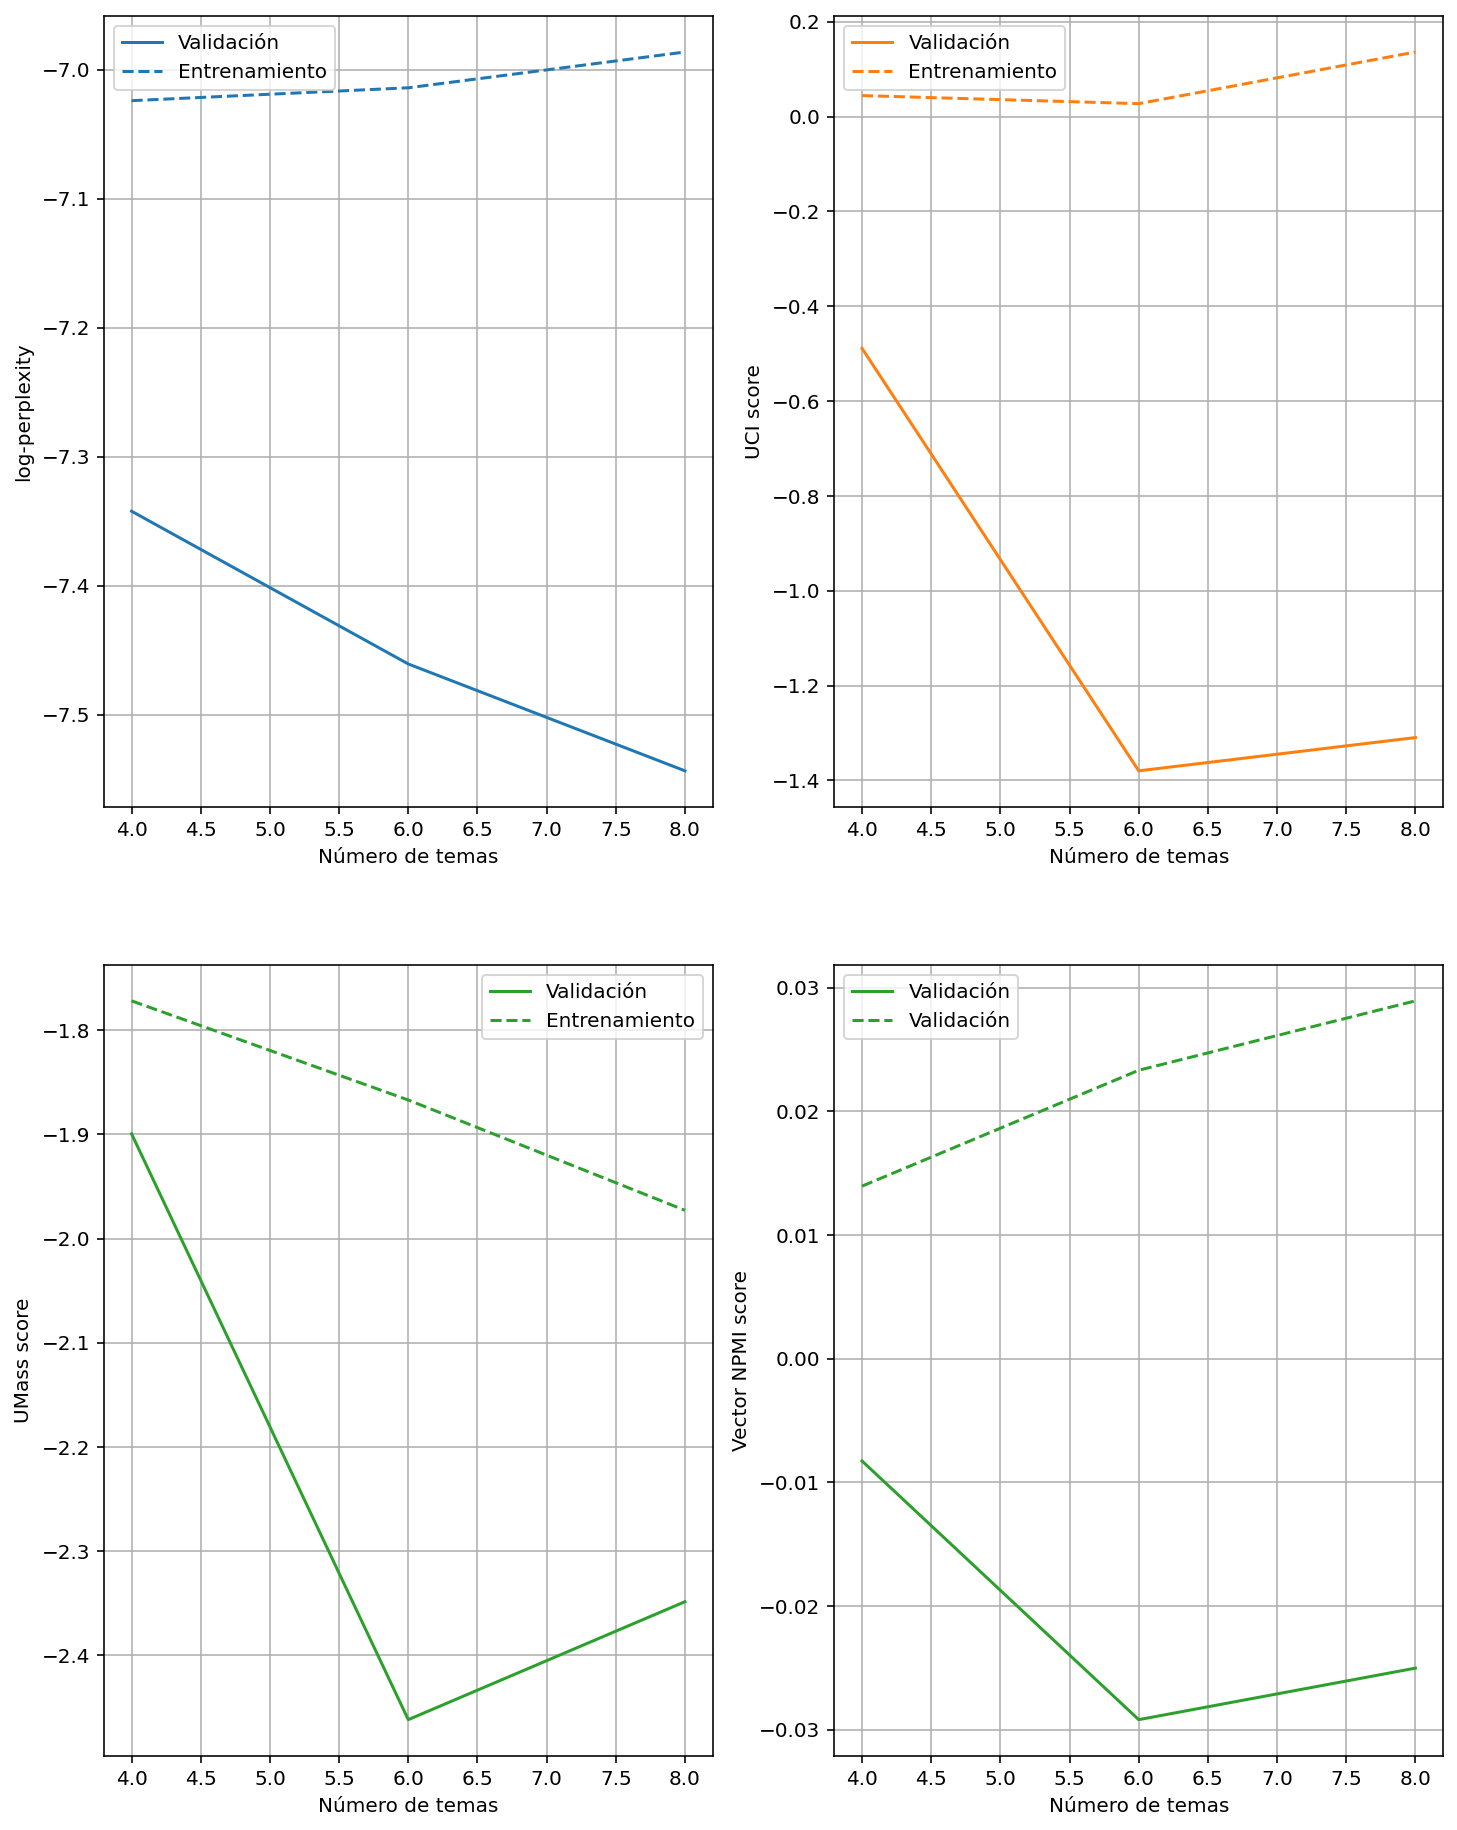

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(12,16))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

axes[0,0].plot(range(4,K_max,2),L_perp,color=cols[0],label='Validación')
axes[0,0].plot(range(4,K_max,2),L_perp_train,'--',color=cols[0],label='Entrenamiento')
axes[0,0].set_ylabel('log-perplexity')
axes[0,0].set_xlabel('Número de temas')
axes[0,0].legend()
axes[0,0].grid()

axes[0,1].plot(range(4,K_max,2),L_UCI,color=cols[1],label='Validación')
axes[0,1].plot(range(4,K_max,2),L_UCI_train,'--',color=cols[1],label='Entrenamiento')
axes[0,1].set_ylabel('UCI score')
axes[0,1].set_xlabel('Número de temas')
axes[0,1].legend()
axes[0,1].grid()

axes[1,0].plot(range(4,K_max,2),L_mass,color=cols[2],label='Validación')
axes[1,0].plot(range(4,K_max,2),L_mass_train,'--',color=cols[2],label='Entrenamiento')
axes[1,0].set_ylabel('UMass score')
axes[1,0].set_xlabel('Número de temas')
axes[1,0].legend()
axes[1,0].grid()

axes[1,1].plot(range(4,K_max,2),L_NPMI,color=cols[2],label='Validación')
axes[1,1].plot(range(4,K_max,2),L_NPMI_train,'--',color=cols[2],label='Validación')
axes[1,1].set_ylabel('Vector NPMI score')
axes[1,1].set_xlabel('Número de temas')
axes[1,1].legend() 
axes[1,1].grid()

## Visualización del modelo de tópicos con pyLDAvis

Vamos a visualizar el mejor modelo encontrado con la librería [pyLDAvis](https://github.com/bmabey/pyLDAvis):

In [22]:
#!pip install pyldavis

In [23]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [24]:
data = pyLDAvis.gensim.prepare(topic_models[8], corpus_bow, D)
pyLDAvis.save_html(data, "LDAvis.html")

/Users/olmos/opt/anaconda3/envs/gensim37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/olmos/opt/anaconda3/envs/gensim37/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/olmos/opt/anaconda3/envs/gensim37/lib/python3.7/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/olmos/opt/anaconda3/envs/gensim37/lib/python3.7/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version ins

La visualización de pyLDAvis nos ofrece la siguiente información:

* **Intertopic distance map (panel de la izquierda)** visualización 2D de los temas. El área por tema es proporcional al **número de palabras que pertenecen a cada tema** en nuestro corpus. Recordad que en el modelo generativo cada palabra se muestrea de un tema en particular, durante la inferencia LDA obtenemos el tema asociado a cada palabra.  Además, los circulos se dibujan en un espacio 2D usando el algoritmo [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling), que proyecta la distribución de cada tema $\beta_k$, $k=1,\ldots,K$ en 2D **manteniendo aproximadamente las distancias entre puntos**.

* **Palabras más importantes del corpus**, definidas como aquellas que maximizan el siguiente *saliency score*:

$$s(w) = p(w) * \sum_{k=0}^{K} p(k|w) \log(\frac{ p(k|w)}{p(k)})$$

obsérvese que cada uno de los términos del sumatorio representan la divergencia KL entre la distribución a posteriori de los temas dada la palabra $w$ ($p(k|w)$) y la probabilidad a priori de los mismos ($p(k)$). 

* **Palabras más relevantes por tema**. Si $\beta_{k,w}=p(w|k)$ es la probabilidad de la palabra $w$ en el tema $k$, se calcula su relevancia como 

$$r(w,k|\lambda) = \lambda *\log(\beta_{k,w}) + (1-\lambda) \log(\frac{\beta_{k,w}}{p(w)})$$

donde $p(w)$ es la probabilidad de palabra en el corpus. Para $\lambda=1$ ordenamos las palabras según su probabilidad en el tema, para $\lambda=0$, penalizamos aquellas palabras más probables en el corpus. Esto puede ayudar a interpretar mejor cada tema al filtrar palabras que aparecen en varios temas.
